In [1]:
import matplotlib.pyplot as plt
from datetime import datetime
from pylab import rcParams
import pandas as pd
import gzip
import pickle
import numpy as np
import glob
import os

In [3]:
def rmse(prediction_errors):
    return (prediction_errors ** 2).mean() ** 0.5

In [46]:
def loglik_from_pickled(dirname):
    return np.concatenate(list(pickle.load(gzip.open(f, 'rb'))['loglik'][:250]
        for f in glob.glob(os.path.join(dirname, 'fit*_extract.pkl.gz')))).mean()

In [5]:
def plot_quarterly(model_name, mean_predictions, ci_95_half_widths, y_test_2014):
    def add_date_index(values):
        return pd.Series(values, 
                         index=pd.date_range(start=datetime(2014, 1, 1), end=datetime(2014, 12, 30)))
                
    def rmse(prediction_errors):
        return (prediction_errors ** 2).mean() ** 0.5
    
    def filter_date_range(series, from_date_inclusive, to_date_inclusive):
            return series\
                [lambda df: df.index >= from_date_inclusive]\
                [lambda df: df.index < to_date_non_inclusive]
    
    plt.tight_layout()
    for i, (quarter, from_date_inclusive, to_date_non_inclusive) in enumerate([
        ('Q1', datetime(2014, 1, 1), datetime(2014, 4, 1)),
        ('Q2', datetime(2014, 4, 1), datetime(2014, 7, 1)),
        ('Q3', datetime(2014, 7, 1), datetime(2014, 10, 1)),
        ('Q4', datetime(2014, 10, 1), datetime(2014, 12, 31))
    ]):    
        
        plt.subplot(411 + i)
        plt.plot(filter_date_range(y_test_2014, from_date_inclusive, to_date_non_inclusive), "b-", label='Actual', lw=1.5)
        plt.plot(filter_date_range(mean_predictions, from_date_inclusive, to_date_non_inclusive), "r-x", label='Predicted', lw=1)
        plt.fill_between(filter_date_range(y_test_2014, from_date_inclusive, to_date_non_inclusive).index, 
                         filter_date_range(mean_predictions + ci_95_half_widths, from_date_inclusive, to_date_non_inclusive),
                         filter_date_range(mean_predictions - ci_95_half_widths, from_date_inclusive, to_date_non_inclusive),
                         color='lightgrey', label='95% C.I.')
        plt.legend(loc='lower left', fontsize=12)
        plt.text(0.01, 0.9, quarter, fontsize=20,
                 horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes)
        if i == 0:
            plt.title(model_name, fontsize=20)
    
    return rmse(filter_date_range(mean_predictions, datetime(2014, 1, 1), datetime(2014, 12, 31)) -
                filter_date_range(y_test_2014, datetime(2014, 1, 1), datetime(2014, 12, 31)))

In [42]:
def plot_predictions_from_pickled(results_directory, model_name):
    rcParams['figure.figsize'] = 16, 10
    prediction_samples = np.concatenate(list(pickle.load(gzip.open(f, 'rb'))['y_pred'][:250, -7:]
        for f in glob.glob(os.path.join(results_directory, 'fit*_extract.pkl.gz'))), axis=1)
    sample_size = prediction_samples.shape[0]
    
    def add_date_index(values):
        return pd.Series(values, 
                         index=pd.date_range(start=datetime(2014, 1, 1), end=datetime(2014, 12, 30)))
    
    mean_predictions = add_date_index(prediction_samples.mean(axis=0))
    std_predictions = add_date_index(prediction_samples.std(axis=0))
    ci_95_hw = 1.96 * std_predictions / (sample_size ** 0.5)
    
    births_2000s_df = pd.read_csv('US_births_2000-2014_SSA.csv')
    y_test_2014 = births_2000s_df\
        .rename(columns={'date_of_month': 'day'})\
        .set_index(pd.to_datetime(
            births_2000s_df.rename(columns={'date_of_month': 'day'})
            [['year', 'month', 'day']]))\
        .births[lambda df: df.index >= datetime(2014, 1, 1)]
    
    return {
        'rmse': plot_quarterly(model_name, mean_predictions, ci_95_hw, y_test_2014),
        'loglik': loglik_from_pickled(results_directory)
    }

{'loglik': -56.40409526913181, 'rmse': 903.9586757116542}

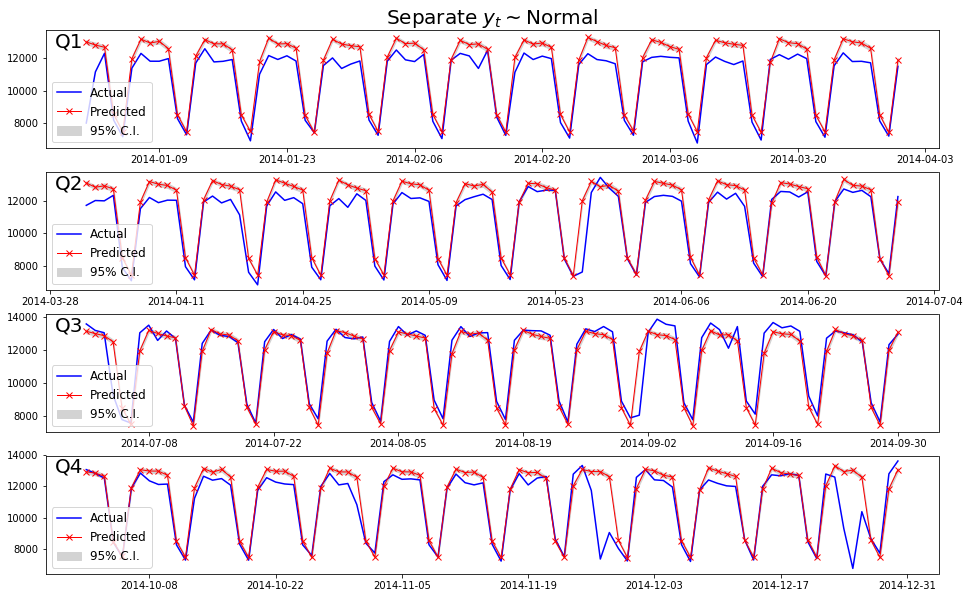

In [28]:
plot_predictions_from_pickled('fit_separate', 'Separate $y_t \sim$Normal')

{'loglik': -287.4199782700962, 'rmse': 897.1197308831815}

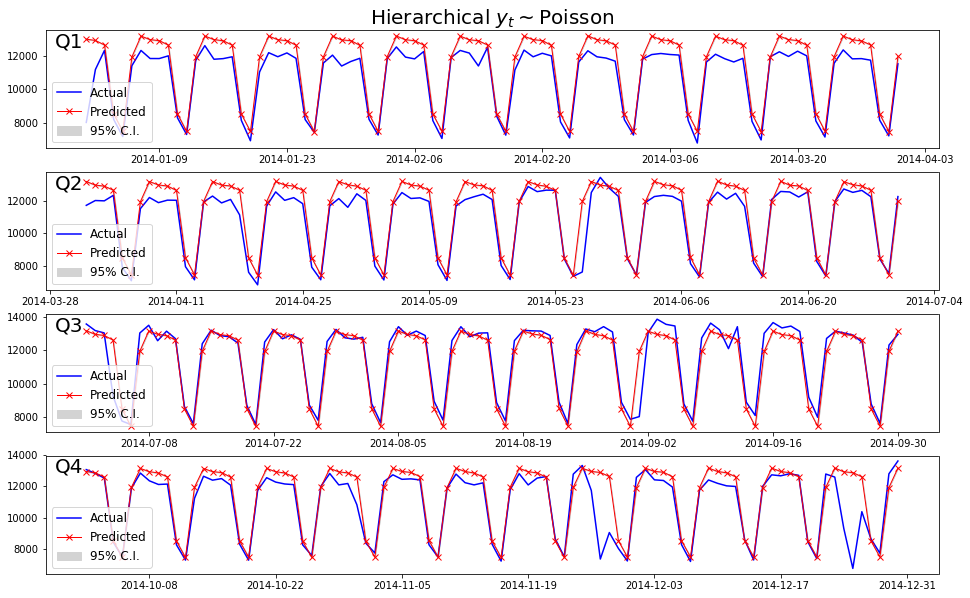

In [29]:
plot_predictions_from_pickled('fit_hier_poisson', 'Hierarchical $y_t \sim$Poisson')

{'loglik': -56.67359816246555, 'rmse': 896.8871826563911}

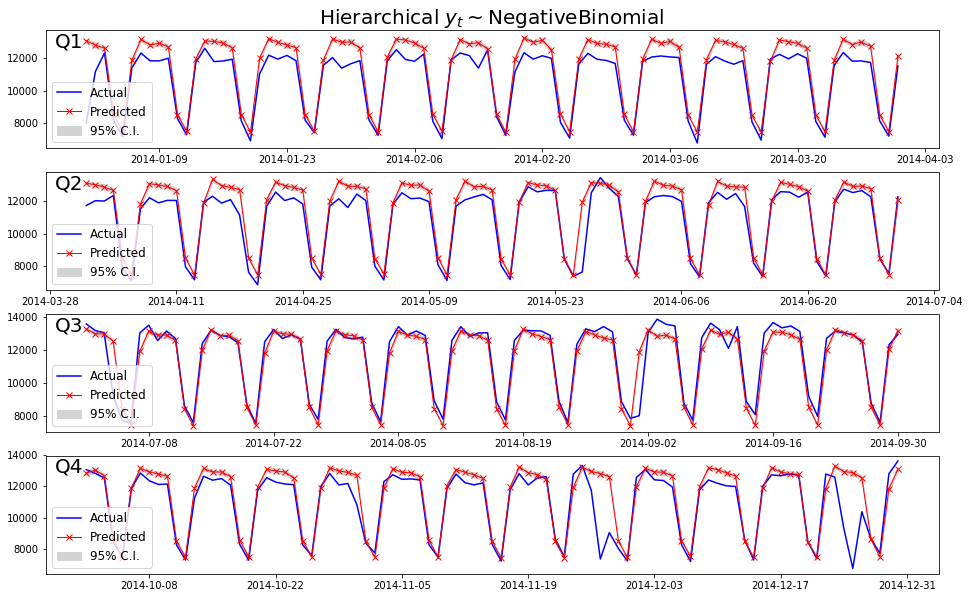

In [30]:
plot_predictions_from_pickled('fit_hier_negbin_one_phi', 'Hierarchical $y_t \sim$NegativeBinomial')

1111.2061298212548


{'loglik': -57.78229544327421, 'rmse': 1111.2061298212548}

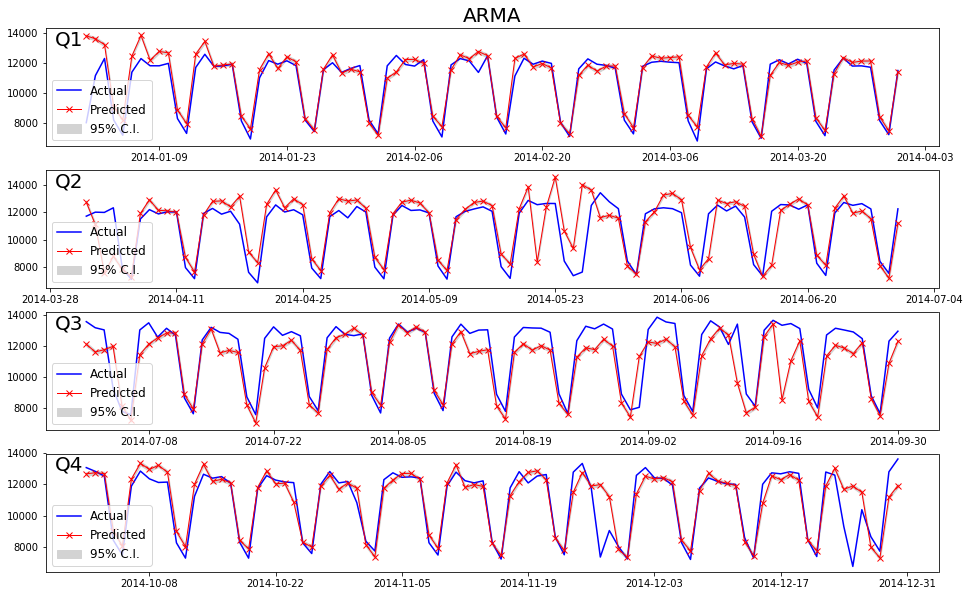

In [33]:
plot_predictions_from_pickled('fit_arima', 'ARMA')